For this homework, we use MovieLens 100K Dataset:
http://grouplens.org/datasets/movielens/100k/ to build a recommendation system. The data was
collected through the MovieLens web site movielens.umn.edu during the seven-month period from
September 19th, 1997 through April 22nd, 1998. It has been cleaned up - users who had less than
20 ratings or did not have complete demographic information were removed from this dataset.
Detailed descriptions of the data file can be found at README.txt on the website. The 100K
MovieLens data consists of 100,000 anonymous ratings on a five-star scale from 1,000 users on
1,700 movies. There are four user-related covariates, including gender, age, occupation and zip
code. We will treat age as continuous variables, and gender and occupation as categorical variables.
For zip code, we can view it as continuous variable since it is incremented from east coast to west
coast with sequential ordering. There are 24 item-related covariates. The last 19 covariates stand
for 19 different movie genres that are reparameterized into binary covariates encoding if certain
movie belongs to a particular genre. Movies can be in several genres at the same time. (Multi-hot
encoding)


In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()

Saving allbut.pl to allbut.pl
Saving mku.sh to mku.sh
Saving README to README
Saving u.data to u.data
Saving u.genre to u.genre
Saving u.info to u.info
Saving u.item to u.item
Saving u.occupation to u.occupation
Saving u.user to u.user
Saving u1.base to u1.base
Saving u1.test to u1.test
Saving u2.base to u2.base
Saving u2.test to u2.test
Saving u3.base to u3.base
Saving u3.test to u3.test
Saving u4.base to u4.base
Saving u4.test to u4.test
Saving u5.base to u5.base
Saving u5.test to u5.test
Saving ua.base to ua.base
Saving ua.test to ua.test
Saving ub.base to ub.base
Saving ub.test to ub.test


In [0]:
#column headers for the dataset
# Set your work directory to where the data is located
# os.chdir("ml-100k/")
data_cols = ['user id','movie id','rating','timestamp']
item_cols = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
'Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance ','Sci-Fi','Thriller',
'War' ,'Western']
user_cols = ['user id','age','gender','occupation',
'zip code']
#importing the data files onto dataframes
users = pd.read_csv('u.user', sep='|',
names=user_cols, encoding='latin-1')
item = pd.read_csv('u.item', sep='|',
names=item_cols, encoding='latin-1')
data = pd.read_csv('u.data', sep='\t',
names=data_cols, encoding='latin-1')

### 1.Use any method of your choice to predict preference scores of each user. Use 5 fold cross-validation for training and testing, and report the average root mean square error (RMSE).  
Specifically, for each pair, train your model on the training set,compute RMSE on the testing set and take average in the end.


Here I try to use two methods.
__SVD and ALS__

In [0]:
# svd RS
def svd_rs(train,test,k=50,users=users,item = item):
    #train df is the original one with usid,movie rating,...time
    ##
    n_user = users.shape[0]
    n_mov = item.shape[0]
    rating_train =pd.DataFrame( train.pivot(index = "user id",columns="movie id", values = "rating"))
    #add blak row or col if user or movie not appear in the item or users sets
    unpre_userid = users['user id'].loc[users['user id'].isin(train['user id'])==False]
    unpre_movid = item['movie id'].loc[item['movie id'].isin(train['movie id'])==False]
    for ID in unpre_userid:
        rating_train.loc[id,:]=np.nan
    for MOVID in unpre_movid:
        rating_train.loc[:,MOVID]=np.nan
#     print('The rated table is created')
#     print("the missing rate is {:.2%}".format(train.shape[0]/(n_user*n_mov)))
    R = rating_train.as_matrix()
    user_rating_mean = np.nanmean(R,axis = 1)  

    rating_train =rating_train.T.fillna(rating_train.mean(axis=1)).T
    R = rating_train.as_matrix()
    R_demeaned = R - user_rating_mean.reshape(-1,1)  
    from scipy.sparse.linalg import svds
    U,sigma ,Vt = svds(R_demeaned,k = 50)
    sigma =np.diag(sigma)
    all_user_pred_rating = np.dot(np.dot(U,sigma),Vt)+user_rating_mean.reshape(-1,1)
    
    pred_df = pd.DataFrame(all_user_pred_rating,columns = rating_train.columns,index = rating_train.index)
    pred_rating = []
    
    tmp1 =test['movie id'].isin(set(train['movie id']))==False
    tmp2 =test['user id'].isin(set(train['user id']))==False
    
    print("the cold start case rate is {:.2%}".format(sum(tmp1+tmp2)/test.shape[0]))     

#    from tqdm import tqdm
 #   with tqdm(total=test.shape[0],desc = "predicting progress") as pbar:
    for row in test.itertuples():
        curid =row[1]
        curmov = row[2]
        pred_rating.append(pred_df.loc[curid,curmov])
    #      pbar.update(1)
    test['pred_rating']= pred_rating
    

    rmse = (np.mean((test['rating']-test['pred_rating'])**2))**0.5
    return test ,rmse

  
def ALS(train,test,k=3,lamb =2,iter_time =0, threshold = 10**-10,plot = False):
    import matplotlib.pyplot as pl
    import matplotlib.pyplot as plt
    m = n_user = users.shape[0]
    n = n_mov = item.shape[0]
    delta = 100
    rating_train =pd.DataFrame( train.pivot(index = "user id",columns="movie id", values = "rating"))
    #add blak row or col if user or movie not appear in the item or users sets
    unpre_userid = users['user id'].loc[users['user id'].isin(train['user id'])==False]
    unpre_movid = item['movie id'].loc[item['movie id'].isin(train['movie id'])==False]
    for ID in unpre_userid:
        rating_train.loc[id,:]=np.nan
    for MOVID in unpre_movid:
        rating_train.loc[:,MOVID]=np.nan
#     print('The rated table is created')
    print("the missing rate is {:.2%}".format(1-train.shape[0]/(n_user*n_mov)))
    rating_train =rating_train.fillna(0)
    R = rating_train.as_matrix()


    def myfunc(x):
        if x>0:return(1)
        else:return(0)

    W = np.vectorize(myfunc)(R)


    X = np.array([[1]*k]*m,dtype =  'float64' )
    Y = np.array([[1]*k]*n,dtype =  'float64' )
    rmse_train =[]
    total = iter_time
#     from tqdm import tqdm
#     with tqdm(total=iter_time,desc = "training progress") as pbar:
    while delta> threshold and iter_time >0:
        R_hat = np.dot(X,Y.T)
        rmse_prv = np.mean((R_hat-R)**2)**0.5
       # print(rmse_prv)
        for u in range(m):
            #update x_u
            W_u = np.diag(W[u,])
            part = np.dot(Y.T,Y)+np.dot(np.dot(Y.T,(W_u-np.identity(n))),Y)
            part1 = np.linalg.inv(part+lamb*np.identity(k))
            X[u,] = np.dot(np.dot(np.dot(part1,Y.T),W_u),(R[u,:]))

        for i in range(n):
            #update y_i  
            W_i = np.diag(W[:,i])
            part = np.dot(X.T,X)+np.dot(np.dot(X.T,(W_i-np.identity(m))),X)
            part1 = np.linalg.inv(part+ lamb*np.identity(k))
            Y[i,] = np.dot(np.dot(np.dot(part1,X.T),W_i),(R[:,i]))

        R_hat = np.dot(X,Y.T)
        rmse = np.mean((R_hat-R)**2)**0.5
        rmse_train.append(rmse)
        delta = np.abs(rmse-rmse_prv)

        all_user_pred_rating = np.dot(X,Y.T)
        pred_rating = []
        pred_df = pd.DataFrame(all_user_pred_rating,columns = rating_train.columns,index = rating_train.index)
#         from tqdm import tqdm
#         with tqdm(total=test.shape[0],desc = "predicting progress") as pbar:
        for row in test.itertuples():
            curid =row[1]
            curmov = row[2]
            pred_rating.append(pred_df.loc[curid,curmov])
#                 pbar.update(1)
        test['pred_rating']= pred_rating
        rmse_test = (np.mean((test['rating']-test['pred_rating'])**2))**0.5
#             print('The rmse for testset is {}'.format(rmse_test))   
        iter_time -=1
#             pbar.update(1)
    
    
    if delta < threshold:print("converge under the threshold= {} with {} iteration times".format(threshold,total-iter_time))
    if plot == True:
      x = range(total-iter_time)
      plt.plot(x,rmse_train)
      plt.xticks(x)
      plt.ylabel("Error ")
      plt.xlabel("iteration times")
      plt.title("RMSE for trainset")
      plt.show()

    all_user_pred_rating = np.dot(X,Y.T)
    pred_rating = []
    pred_df = pd.DataFrame(all_user_pred_rating,columns = rating_train.columns,index = rating_train.index)
#     from tqdm import tqdm
#     with tqdm(total=test.shape[0],desc = "predicting progress") as pbar:
    for row in test.itertuples():
        curid =row[1]
        curmov = row[2]
        pred_rating.append(pred_df.loc[curid,curmov])
#             pbar.update(1)
    test['pred_rating']= pred_rating
    rmse = (np.mean((test['rating']-test['pred_rating'])**2))**0.5
#     print('The rmse for testset is {}'.format(rmse))   
    return(test,rmse)

    

In [0]:
rmse_list = []
for i in range(1,6):
  train = pd.read_csv('u'+str(i)+'.base', sep='\t',names = data_cols,header=None)
  test = pd.read_csv('u'+str(i)+'.test', sep='\t',names = data_cols, header=None)
  test_new ,rmse = svd_rs(train,test,k=50)   
  rmse_list.append(rmse)
print("The cv rmse for svd is {}".format(np.mean(rmse_list)))

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


the cold start case rate is 0.16%
the cold start case rate is 0.18%
the cold start case rate is 0.18%
the cold start case rate is 0.14%
the cold start case rate is 0.18%
The cv rmse for svd is 1.0074007932836817


In [0]:
rmse_list = []
for i in range(1,6):
  train = pd.read_csv('u'+str(i)+'.base', sep='\t',names = data_cols,header=None)
  test = pd.read_csv('u'+str(i)+'.test', sep='\t',names = data_cols, header=None)
  test_new ,rmse = ALS(train,test,k=2,lamb =2,iter_time =5, threshold = 10**-10)
  rmse_list.append(rmse)
print("The cv rmse for Als is {}".format(np.mean(rmse_list)))

the missing rate is 94.96%
the missing rate is 94.96%
the missing rate is 94.96%
the missing rate is 94.96%
the missing rate is 94.96%
The cv rmse for Als is 0.9562100392853516


### 2. For this dataset, many ratings are not observed or missing. Do you have any evidence to suggest that missing does not occur at random? 

The blow pictures show the missin does not occur at random. Assume the missing is random.  
*  The heatmap for the Pic1 should be even coloured. But the plot is obviously not. (have more density on certain movie id or user id)  
* The second plot shows that the according to the user's number of rating, the distribution of users are not noraml distribution,which is the evidence for the missing pattern is not random.  
* The third plot show the more number of rating for a specific movie, the higher the rating for that movie.  
* The last plot show the rating distribution according to the number of movie user seen(label by the gender). The distribution is different in two gender groups.

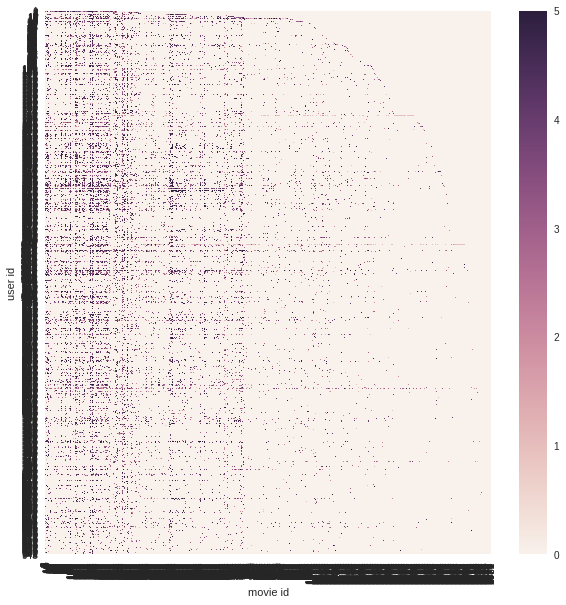

In [0]:
rating_train =pd.DataFrame( train.pivot(index = "user id",columns="movie id", values = "rating"))
#add blak row or col if user or movie not appear in the item or users sets
unpre_userid = users['user id'].loc[users['user id'].isin(train['user id'])==False]
unpre_movid = item['movie id'].loc[item['movie id'].isin(train['movie id'])==False]
for ID in unpre_userid:
    rating_train.loc[id,:]=np.nan
for MOVID in unpre_movid:
    rating_train.loc[:,MOVID]=np.nan
# print('The rated table is created')
# print("the missing rate is {:.2%}".format(1-train.shape[0]/(n_user*n_mov)))
rating_train =rating_train.fillna(0)
fig =plt.figure(figsize=(10,10))
sns.heatmap(rating_train)
# plt.title("The missing percentage according to all level")
plt.show()

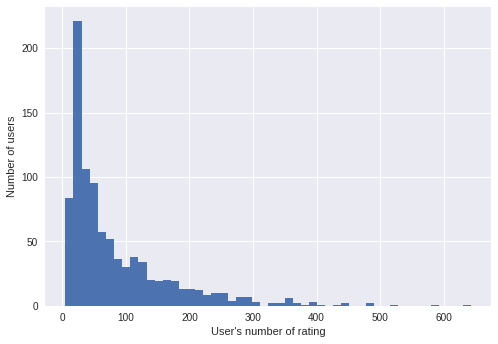

In [0]:
user_movie = train.groupby("user id")['movie id'].count()
plt.hist(user_movie,bins = 50)
plt.ylabel("Number of users")
plt.xlabel("User's number of rating")
plt.show()

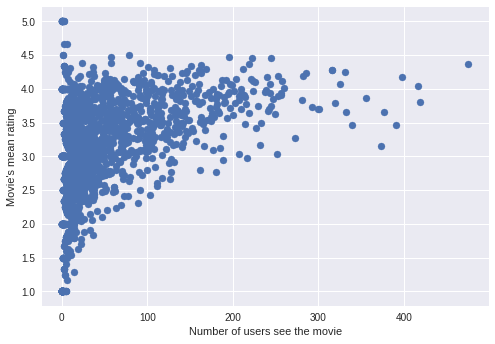

In [0]:
tmp1 = train.groupby("movie id")['rating',].count()
tmp2 = train.groupby("movie id")['rating'].mean()
plt.scatter(tmp1,tmp2 )
plt.xlabel("Number of users see the movie")
plt.ylabel("Movie's mean rating")
plt.show()

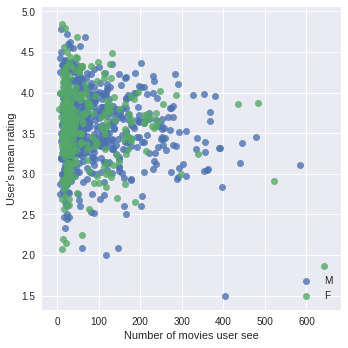

In [0]:
df = train.merge(users,on ="user id")
tmp1= df.groupby("user id")['rating'].count()
tmp2 = df.groupby("user id")['rating'].mean()
tmp3 = df.groupby("user id")['gender'].first().values
df = pd.DataFrame({'1':tmp1,'2':tmp2,'3':tmp3})
import seaborn as sns
sns.lmplot( x="1", y='2', data=df, fit_reg=False, hue='3', legend=False)
plt.xlabel("Number of movies user see")
plt.ylabel("User's mean rating")
plt.legend(loc='lower right')
plt.show()

### 3. If the goal is to build a recommender system with a high accuracy of prediction, then demonstrate that the predictive performance can be enhanced by incorporating the missing pattern.

From the previous analysis, there is certian relationship between missing pattern and the distribution of User information like gender. So we add more information in the model.

To solve this problem here I use the explicit MF with contents and user information.
https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

To involve more user and item feature,  I adjust the model :  
$ \hat{r_{ui}} =\mu+ F_ub_u+F_ib_i+X_u^tYi $  
So the __loss function__: $L = \sum_{ui}(r_{ui}-\hat{r_{ui}} )+\lambda_{xb}\sum_{u}||b_u||^2+\lambda_{yb}\sum_{u}||b_i||^2+\lambda_{xf}\sum_{u}||X_u||^2+\lambda_{yf}\sum_{u}||Y_i||^2$  
Use stochastic gradient descent, to get the update equation:  
$ \frac{\partial{L}}{F_i} = -e_{u_i}b_i +\lambda_{F_i}F_i \space \space \rightarrow F_i^{new}=F_i +e_{u_i}b_i-\lambda_{F_i}F_i$  
$ \frac{\partial{L}}{F_u} = -e_{u_i}b_u +\lambda_{F_u}F_u \space \space \rightarrow F_u^{new}=F+u -e_{u_i}b_u-\lambda_{F_u}F_u$  
$ \frac{\partial{L}}{X_u} = -e_{u_i}Y_i +\lambda_{X_U}X_u \space \space \rightarrow X_u^{new}=X_u +e_{u_i}Y_i-\lambda_{X_u}X_u$  
$ \frac{\partial{L}}{Y_u} = -e_{u_i}X_i +\lambda_{Y_i}Y_i \space \space \rightarrow Y_u^{new}=Y_u +e_{u_i}X_u-\lambda_{Y_i}y_i$  
  
$\mu $  for all user' mean rating across all movies  
$b_u$  userbias vector  
$b_i$  itembias vector

So in the end the prediction for $r_{ui}= \mu +F_ub_u+F_iB_i+X_u^tY_i$

In [0]:

def CMF(train,test,n_f =5,lamb =10**-1,learningrate = 10**-3,iter_time  = 100,plot= False):
    n_user = users.shape[0]
    n_mov = item.shape[0]
    n_u= m = n_user  
    n_i = n = n_mov 
    ###

    rating_train =pd.DataFrame( train.pivot(index = "user id",columns="movie id", values = "rating"))
    #add blak row or col if user or movie not appear in the item or users sets
    unpre_userid = users['user id'].loc[users['user id'].isin(train['user id'])==False]
    unpre_movid = item['movie id'].loc[item['movie id'].isin(train['movie id'])==False]
    for ID in unpre_userid:
        rating_train.loc[id,:]=np.nan
    for MOVID in unpre_movid:
        rating_train.loc[:,MOVID]=np.nan
#     print('The rated table is created')
    print("the missing rate is {:.2%}".format(1-train.shape[0]/(n_user*n_mov)))
    rating_train =rating_train.fillna(0)
    R = rating_train.as_matrix()
    Mu = np.mean(train['rating'])
    Bi = pd.DataFrame(item.iloc[:,5:]).as_matrix()
    n_bi = np.shape(Bi)[1]
    Fi =  np.random.normal(scale = 1/n_bi,size = (n_i,n_bi))
    from sklearn.preprocessing import LabelEncoder
    lb_make = LabelEncoder()
    Bu = lb_make.fit_transform(users['gender']).reshape((-1,1))
    n_bu = np.shape(Bu)[1]
    Fu =  np.random.normal(scale = 1/n_bu,size = (n_u,n_bu))
    X = np.random.normal(scale = 1/n_f,size = (n_u,n_f))
    Y = np.random.normal(scale = 1/n_f,size = (n_i,n_f))
    def pred(x,y,fi,bi,fu,bu,Mu):
      pred = np.dot(x.T,y)+np.dot(fi.T,bi)+np.dot(fu.T,bu)+Mu
      return(pred)

    RMSE_prv =0

    rmse_train =[]
    rmse_test=[]
    threshold = 10**-5

    # with tqdm(total=iter_time,desc = "traing epoch ") as pbar:
    for i in range(iter_time):
        SSEtrain = 0
        # for each record in the train set
        for rating in train.itertuples():
            xu = X[(rating[1] - 1),:].reshape((-1,1))
            yi = Y[(rating[2]-1),:].reshape((-1,1))
            bi = Bi[(rating[2] - 1),:].reshape((-1,1))
            fi = Fi[(rating[2]-1),:].reshape((-1,1))
            bu = Bu[(rating[1] - 1),:].reshape((-1,1))
            fu = Fu[(rating[1] - 1),:].reshape((-1,1))

            prediction = pred(xu,yi,fi,bi,fu,bu,Mu)


            if prediction < 1:
                prediction = 1
            elif prediction > 5:
                prediction = 5
            error = rating[3] - prediction
            SSEtrain += error**2
            # update matrices X,Y,Bi,Bu,Fi,Fu
            Fu[(rating[1]-1), :] = Fu[(rating[1] - 1), :]+ learningrate*(error*bu -lamb*fu).reshape(1,-1)
            X[(rating[1]-1), :] = X[(rating[1] - 1), :]+ learningrate*(error*yi -lamb*xu).reshape(1,-1)
            Fi[(rating[2]-1), :] = Fi[(rating[2] - 1), :]+ learningrate*(error*bi -lamb*fi).reshape(1,-1)
            Y[(rating[2]-1), :] = Y[(rating[2] - 1), :]+ learningrate*(error*xu -lamb*yi).reshape(1,-1)     
        RMSEiter = np.sqrt(SSEtrain / len(train))[0][0]    
        rmse_train.append(RMSEiter**0.5)
        if np.abs(RMSEiter-RMSE_prv )> threshold :
            RMSE_prv = RMSEiter
        else:break
    #       pbar.update(1)

    pred_rating = []

    for rating in test.itertuples():
        xu = X[(rating[1] - 1),:].reshape((-1,1))
        yi = Y[(rating[2]-1),:].reshape((-1,1))
        bi = Bi[(rating[2] - 1),:].reshape((-1,1))
        fi = Fi[(rating[2]-1),:].reshape((-1,1))
        bu = Bu[(rating[1] - 1),:].reshape((-1,1))
        fu = Fu[(rating[1] - 1),:].reshape((-1,1))
        pred_rating.append( pred(xu,yi,fi,bi,fu,bu,Mu))

    test['pred_rating']= pred_rating
    rmse = (np.mean((test['rating']-test['pred_rating'])**2))**0.5
    print('The rmse for traintset is {}'.format(RMSEiter**0.5))
    print('The rmse for testset is {}'.format(rmse))
    rmse_test.append(rmse)

    if plot == True:
      import matplotlib.pyplot as plt
      x = range(len(rmse_train))
      plt.plot(x,rmse_train,label = "train")
      plt.plot(x,rmse_test,label = "test")
      plt.xticks()
      plt.ylabel("Error ")
      plt.xlabel("iteration times")
      plt.title("RMSE for train and test")
      plt.legend()
      plt.show()
    return(test,rmse)
        

In [0]:
rmse_list = []
from tqdm import tqdm
with tqdm(total=5,desc = "cv set") as pbar:
    for i in range(1,6):
      train = pd.read_csv('u'+str(i)+'.base', sep='\t',names = data_cols,header=None)
      test = pd.read_csv('u'+str(i)+'.test', sep='\t',names = data_cols, header=None)
      test_new ,rmse = CMF(train,test,n_f =5,lamb =10**-1,learningrate = 5*10**-3,iter_time  = 150)  
      rmse_list.append(rmse)
      pbar.update(1)
print("The cv rmse for CMF is {}".format(np.mean(rmse_list)))

cv set:   0%|          | 0/5 [00:00<?, ?it/s]

the missing rate is 94.96%


cv set:  20%|██        | 1/5 [10:25<41:43, 625.83s/it]

The rmse for traintset is 0.9051676138272351
The rmse for testset is [[0.94797776]]
the missing rate is 94.96%


cv set:  40%|████      | 2/5 [20:48<31:14, 624.90s/it]

The rmse for traintset is 0.906443263510244
The rmse for testset is [[0.94434054]]
the missing rate is 94.96%


cv set:  60%|██████    | 3/5 [30:29<20:23, 611.57s/it]

The rmse for traintset is 0.9062112352551887
The rmse for testset is [[0.93112097]]
the missing rate is 94.96%


cv set:  80%|████████  | 4/5 [40:00<09:59, 599.58s/it]

The rmse for traintset is 0.9072040180615139
The rmse for testset is [[0.92934612]]
the missing rate is 94.96%


cv set: 100%|██████████| 5/5 [51:15<00:00, 622.17s/it]

The rmse for traintset is 0.905837840013844
The rmse for testset is [[0.93312709]]
The cv rmse for CMF is 0.9371824943120386


This is easy to see that compare with the previous SVD(rmse = 1.0074) or ALS(rmse = 0.9562) solution for the original $R = X^T Y$ model. Though, for model ALS. Still in ALS, the stochastic gredient descent for optimization method.   
The new model with $ \hat{r_{ui}} =\mu+ F_ub_u+F_ib_i+X_u^tYi $ which involved the user information and also the movie genre with a lower RMSE = 0.93718